In [1]:
import pandas as pd 
from langchain.schema import Document
from langchain_text_splitters import RecursiveCharacterTextSplitter, CharacterTextSplitter
from langchain_openai import OpenAIEmbeddings
from dotenv import load_dotenv 
import driver.weaviatedb as weaviatedb
import uuid
import os
from typing import Dict, List, Any, Optional
from tqdm import tqdm
load_dotenv('../.env')


True

# About Dataset

The file data/recipes.csv contains information on over 1000 recipes, including recipe names, preparation times, cooking times, ratings, ingredient lists, and step-by-step directions

In this project, I just use for 100 recipes.

- recipe_name: The name of the recipe. (String)
- prep_time: The amount of time required to prepare the recipe. (Integer)
- cook_time: The amount of time required to cook the recipe. (Integer)
- total_time: The total amount of time required to prepare and cook the recipe. (Integer)
- servings: The number of servings the recipe yields. (Integer)
- ingredients: A list of ingredients required to make the recipe. (List)
- directions: A list of directions for preparing and cooking the recipe. (List)
- rating: The recipe rating. (Float)
- url: The recipe URL. (String)
- cuisine_path: The recipe cuisine path. (String)
- nutrition: The recipe nutrition information. (Dictionary)
- timing: The recipe timing information. (Dictionary)
- img_src: Links to the image of the recipe

This dataset from Kaggle: [Recipes Dataset](https://www.kaggle.com/datasets/thedevastator/better-recipes-for-a-better-life)


# Data Processing

In [2]:
path = "/home/kdts34/LLM/cuonghv/Recipe_Assistance/data/recipes.csv" 
df = pd.read_csv(path)
df.head()

,Unnamed: 0,recipe_name,prep_time,cook_time,total_time,servings,yield,ingredients,directions,rating,url,cuisine_path,nutrition,timing,img_src
0,0,Apple-Cranberry Crostada,NaN,NaN,NaN,8,6 to 8 - servings,"3 tablespoons butter, 2 pounds Granny Smith ap...",Heat butter in a large skillet over medium-hig...,4.4,https://www.allrecipes.com/recipe/76931/apple-...,/Desserts/Fruit Desserts/Apple Dessert Recipes/,"Total Fat 18g 23%, Saturated Fat 7g 34%, Chole...","Servings: 8, Yield: 6 to 8 - servings",https://www.allrecipes.com/thmb/Tf1wH73bfH6Oql...
1,1,Apple Pie by Grandma Ople,30 mins,1 hrs,1 hrs 30 mins,8,1 9-inch pie,"8 small Granny Smith apples, or as needed, ½ c...","Peel and core apples, then thinly slice. Set a...",4.8,https://www.allrecipes.com/recipe/12682/apple-...,/Desserts/Pies/Apple Pie Recipes/,"Total Fat 19g 24%, Saturated Fat 9g 46%, Chole...","Prep Time: 30 mins, Cook Time: 1 hrs, Total Ti...",https://www.allrecipes.com/thmb/1I95oiTGz6aEpu...
2,2,Sarah's Homemade Applesauce,10 mins,15 mins,25 mins,4,NaN,"4 apples - peeled, cored and chopped, ¾ cup w...","Combine apples, water, sugar, and cinnamon in ...",4.8,https://www.allrecipes.com/recipe/51301/sarahs...,/Side Dish/Applesauce Recipes/,"Total Fat 0g 0%, Sodium 3mg 0%, Total Carbohyd...","Prep Time: 10 mins, Cook Time: 15 mins, Total ...",https://www.allrecipes.com/thmb/VY5d0tZHB8xz6y...
3,3,Apple Crisp,30 mins,45 mins,1 hrs 15 mins,12,1 9x13-inch pan,"10 cups all-purpose apples, peeled, cored and ...",Preheat the oven to 350 degrees F (175 degrees...,4.7,https://www.allrecipes.com/recipe/12409/apple-...,/Desserts/Crisps and Crumbles Recipes/Apple Cr...,"Total Fat 8g 11%, Saturated Fat 5g 25%, Choles...","Prep Time: 30 mins, Cook Time: 45 mins, Total ...",https://www.allrecipes.com/thmb/uAzhPOh86PfR-N...
4,4,Apple Pie Filling,20 mins,20 mins,2 hrs 40 mins,40,5 9-inch pies,"18 cups thinly sliced apples, 3 tablespoons le...",Toss apples with lemon juice in a large bowl a...,4.7,https://www.allrecipes.com/recipe/12681/apple-...,/Desserts/Pies/Apple Pie Recipes/,"Total Fat 0g 0%, Sodium 61mg 3%, Total Carbohy...","Prep Time: 20 mins, Cook Time: 20 mins, Additi...",https://www.allrecipes.com/thmb/c0bbYaS1V_mTt_...


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1090 entries, 0 to 1089
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0    1090 non-null   int64  
 1   recipe_name   1090 non-null   object 
 2   prep_time     1039 non-null   object 
 3   cook_time     782 non-null    object 
 4   total_time    1045 non-null   object 
 5   servings      1090 non-null   int64  
 6   yield         879 non-null    object 
 7   ingredients   1090 non-null   object 
 8   directions    1090 non-null   object 
 9   rating        1090 non-null   float64
 10  url           1090 non-null   object 
 11  cuisine_path  1090 non-null   object 
 12  nutrition     1090 non-null   object 
 13  timing        1090 non-null   object 
 14  img_src       1090 non-null   object 
dtypes: float64(1), int64(2), object(12)
memory usage: 127.9+ KB


In [4]:
cleaned_data = df.dropna().reset_index(drop=True)
cleaned_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 631 entries, 0 to 630
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0    631 non-null    int64  
 1   recipe_name   631 non-null    object 
 2   prep_time     631 non-null    object 
 3   cook_time     631 non-null    object 
 4   total_time    631 non-null    object 
 5   servings      631 non-null    int64  
 6   yield         631 non-null    object 
 7   ingredients   631 non-null    object 
 8   directions    631 non-null    object 
 9   rating        631 non-null    float64
 10  url           631 non-null    object 
 11  cuisine_path  631 non-null    object 
 12  nutrition     631 non-null    object 
 13  timing        631 non-null    object 
 14  img_src       631 non-null    object 
dtypes: float64(1), int64(2), object(12)
memory usage: 74.1+ KB


In [5]:
# Just collect 100 rows from cleaned data
data = cleaned_data[:100]

In [6]:
data.head()

,Unnamed: 0,recipe_name,prep_time,cook_time,total_time,servings,yield,ingredients,directions,rating,url,cuisine_path,nutrition,timing,img_src
0,1,Apple Pie by Grandma Ople,30 mins,1 hrs,1 hrs 30 mins,8,1 9-inch pie,"8 small Granny Smith apples, or as needed, ½ c...","Peel and core apples, then thinly slice. Set a...",4.8,https://www.allrecipes.com/recipe/12682/apple-...,/Desserts/Pies/Apple Pie Recipes/,"Total Fat 19g 24%, Saturated Fat 9g 46%, Chole...","Prep Time: 30 mins, Cook Time: 1 hrs, Total Ti...",https://www.allrecipes.com/thmb/1I95oiTGz6aEpu...
1,3,Apple Crisp,30 mins,45 mins,1 hrs 15 mins,12,1 9x13-inch pan,"10 cups all-purpose apples, peeled, cored and ...",Preheat the oven to 350 degrees F (175 degrees...,4.7,https://www.allrecipes.com/recipe/12409/apple-...,/Desserts/Crisps and Crumbles Recipes/Apple Cr...,"Total Fat 8g 11%, Saturated Fat 5g 25%, Choles...","Prep Time: 30 mins, Cook Time: 45 mins, Total ...",https://www.allrecipes.com/thmb/uAzhPOh86PfR-N...
2,4,Apple Pie Filling,20 mins,20 mins,2 hrs 40 mins,40,5 9-inch pies,"18 cups thinly sliced apples, 3 tablespoons le...",Toss apples with lemon juice in a large bowl a...,4.7,https://www.allrecipes.com/recipe/12681/apple-...,/Desserts/Pies/Apple Pie Recipes/,"Total Fat 0g 0%, Sodium 61mg 3%, Total Carbohy...","Prep Time: 20 mins, Cook Time: 20 mins, Additi...",https://www.allrecipes.com/thmb/c0bbYaS1V_mTt_...
3,7,Apple-Cranberry Crisp,25 mins,40 mins,1 hrs 5 mins,8,1 8-inch crisp,"2 pounds Granny Smith apples - peeled, cored a...",Preheat the oven to 375 degrees F (190 degrees...,4.6,https://www.allrecipes.com/recipe/41893/apple-...,/Desserts/Crisps and Crumbles Recipes/,"Total Fat 12g 15%, Saturated Fat 4g 22%, Chole...","Prep Time: 25 mins, Cook Time: 40 mins, Total ...",https://www.allrecipes.com/thmb/MjDDFmBWiEx9f1...
4,10,Apple Turnovers,30 mins,25 mins,55 mins,8,8 turnovers,"2 tablespoons lemon juice, 4 cups water, 4 Gr...",Combine the lemon and 4 cups water in a large ...,4.6,https://www.allrecipes.com/recipe/59124/apple-...,/Desserts/Fruit Desserts/Apple Dessert Recipes/,"Total Fat 26g 33%, Saturated Fat 8g 39%, Chole...","Prep Time: 30 mins, Cook Time: 25 mins, Total ...",https://www.allrecipes.com/thmb/6EpK8eOrDHd4MM...


In [7]:
# Testing function creating the processed data
for i, row in data.iterrows():
    context_columns = ['recipe_name', 'directions', 'prep_time', 'cook_time', 'servings', 'ingredients']
    # recipe_info = f"\n recipe_name: {row['recipe_name']} \n directions: {row['directions']} \n prep_time: {row['prep_time']} \n cook_time: {row['cook_time']} servings: {row['servings']} \n ingredients: {row['ingredients']}"
    context = [f'\n {column}: {row[column]}' for column in context_columns]
    recipe_info = " ".join(context)
    print(f'{i}: {recipe_info}')
    if i == 3:
        break 

0: 
 recipe_name: Apple Pie by Grandma Ople 
 directions: Peel and core apples, then thinly slice. Set aside.
Preheat the oven to 425 degrees F (220 degrees C).
Melt butter in a saucepan over medium heat. Add flour and stir to form a paste; cook until fragrant, about 1 to 2 minutes. Add both sugars and water; bring to a boil. Reduce the heat to low and simmer for 3 to 5 minutes. Remove from the heat.
Press one pastry into the bottom and up the sides of a 9-inch pie pan. Roll out remaining pastry so it will overhang the pie by about 1/2 inch. Cut pastry into eight 1-inch strips.
Place sliced apples into the bottom crust, forming a slight mound. Lay four pastry strips vertically and evenly spaced over apples, using longer strips in the center and shorter strips at the edges.
Make a lattice crust: Fold the first and third strips all the way back so they're almost falling off the pie. Lay one of the unused strips perpendicularly over the second and fourth strips, then unfold the first and 

In [8]:
# Creating processed data
processed_data = pd.DataFrame([])
documents = []
for i, row in data.iterrows():
    context_columns = ['recipe_name', 'directions', 'prep_time', 'cook_time', 'servings', 'ingredients']
    context = [f'\n {column}: {row[column]}' for column in context_columns]
    recipe_info = " ".join(context)
    documents.append(recipe_info)
processed_data['Document'] = documents
processed_data['Url'] = data['url']
processed_data['Text_Length'] = processed_data['Document'].apply(lambda x: len(x.split(' ')))
processed_data.head()

,Document,Url,Text_Length
0,\n recipe_name: Apple Pie by Grandma Ople \n d...,https://www.allrecipes.com/recipe/12682/apple-...,346
1,\n recipe_name: Apple Crisp \n directions: Pre...,https://www.allrecipes.com/recipe/12409/apple-...,153
2,\n recipe_name: Apple Pie Filling \n direction...,https://www.allrecipes.com/recipe/12681/apple-...,152
3,\n recipe_name: Apple-Cranberry Crisp \n direc...,https://www.allrecipes.com/recipe/41893/apple-...,131
4,\n recipe_name: Apple Turnovers \n directions:...,https://www.allrecipes.com/recipe/59124/apple-...,288


In [9]:
processed_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Document     100 non-null    object
 1   Url          100 non-null    object
 2   Text_Length  100 non-null    int64 
dtypes: int64(1), object(2)
memory usage: 2.5+ KB


In [10]:
processed_data['Text_Length'].min()

94

Text(0, 0.5, 'Frequency')

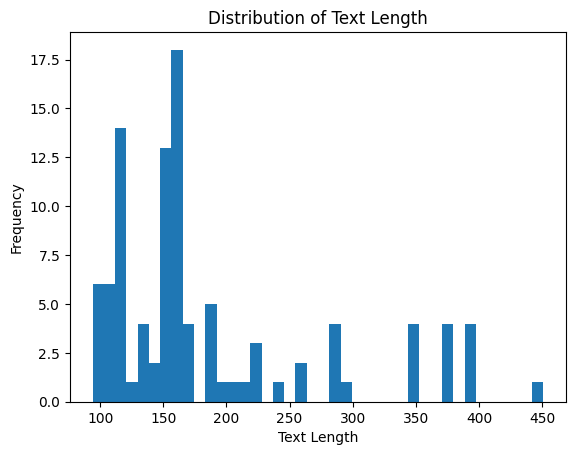

In [11]:
## Plot dist of text_length
ax = processed_data['Text_Length'].plot(kind='hist', bins=40, title='Distribution of Text Length')
ax.set_xlabel('Text Length')
ax.set_ylabel('Frequency')

# Chunking and Embedding

In [12]:
def chunking(method: str):
    """return TextSplitter with one chunking method"""
    if method == 'RecursiveCharacterTextSplitter':
        return RecursiveCharacterTextSplitter(
            # Set a really small chunk size, just to show.
            chunk_size=1000,
            chunk_overlap=200,
            length_function=len,
        )
    elif method == 'CharacterTextSplitter':
        return CharacterTextSplitter(
            separator=" ",
            chunk_size=1000,
            chunk_overlap=200,
            length_function=len,
            is_separator_regex=False,
        )
def get_embed_model_openAI(
    embedding_model: Any = OpenAIEmbeddings,
    embedding_model_params: Optional[Dict[str, Any]] = {'openai_api_key': os.environ.get(
            'OPENAI_API_KEY'), "model": "text-embedding-3-small", 'show_progress_bar': True},
) -> Any:
    return embedding_model(**embedding_model_params)
def import_data_to_db(vectorstore, meta_data, page_content, tenant_name='Admin', index_name=None):
    # [ RecursiveCharacterTextSplitter, CharacterTextSplitter]
    text_splitter = chunking(method='RecursiveCharacterTextSplitter')
    embed_model = get_embed_model_openAI()
    doc = Document(
        metadata=meta_data,
        page_content=page_content,
    )
    documents = text_splitter.create_documents(
        [doc.page_content], metadatas=[doc.metadata]
    )
    if index_name is not None:
        db =  vectorstore.load_document_to_vectordb(
            documents = documents,
            index_name= index_name,
            text_key='text',
            embedding= embed_model, 
            tenant_name = tenant_name
            )
        
    else:
        db =  vectorstore.load_document_to_vectordb(
            documents = documents, 
            embedding= embed_model, 
            tenant_name = tenant_name
            )
    return db._index_name, db._text_key, documents

In [13]:
# init vectorstore
vectorstore = weaviatedb.WeaviateDB()
# create index 
index = f'Recipe_{uuid.uuid4().hex}' 
print(index)

----------self.__host: localhost:8080
----------update_connect_type: ['localhost']
----------hybrid_search: True
Weaviate Client connect with localhost
------VectorDB client: <weaviate.client.WeaviateClient object at 0x7f5b5ba13a90>
Recipe_b8eb8bb414aa4884894a6a2853eb72e9


In [14]:
vectorstore = weaviatedb.WeaviateDB()

for i, row in tqdm(processed_data.iterrows(), total=processed_data.shape[0]):
    # print(f'Imported link: {row["Url"]}')
    db = import_data_to_db(
        vectorstore=vectorstore,
        meta_data={"url": str(row['Url'])},
        page_content=row['Document'],
        tenant_name='Recipe',
        index_name=index  # latest index: Recipe_c26053dbf9cb41929a1476da1a49cb2d
    )

----------self.__host: localhost:8080
----------update_connect_type: ['localhost']
----------hybrid_search: True


/home/kdts34/miniconda3/envs/recipe/lib/python3.10/site-packages/weaviate/warnings.py:305: ResourceWarning: Con004: The connection to Weaviate was not closed properly. This can lead to memory leaks.
            Please make sure to close the connection using `client.close()`.
  warnings.warn(


Weaviate Client connect with localhost
------VectorDB client: <weaviate.client.WeaviateClient object at 0x7f5b854668f0>


  0%|          | 0/100 [00:00<?, ?it/s]2024-Sep-23 10:32 AM - langchain_weaviate.vectorstores - INFO - Tenant Recipe does not exist in index Recipe_b8eb8bb414aa4884894a6a2853eb72e9. Creating tenant.
/home/kdts34/miniconda3/envs/recipe/lib/python3.10/asyncio/selector_events.py:710: ResourceWarning: unclosed transport <_SelectorSocketTransport fd=78 read=idle write=<idle, bufsize=0>>
  _warn(f"unclosed transport {self!r}", ResourceWarning, source=self)
/home/kdts34/miniconda3/envs/recipe/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████| 100/100 [01:11<00:00,  1.39it/s]


# Trace the conversation with Langsmith

In [ ]:
def trace_by_langsmith(
    is_langsmith: bool=False,
    project_name: str='chatbot',
):
    if is_langsmith:
        import os
        print(f'LangChainBot: \tTracing by Langsmith')
        # Define the environment variables
        env_vars = {
            'LANGCHAIN_TRACING_V2': 'true',
            'LANGCHAIN_ENDPOINT': 'https://api.smith.langchain.com',
            'LANGCHAIN_PROJECT': project_name
        }

        for key, value in env_vars.items():
            os.environ[key] = value